# Jack's Car Rental Problem
This notebook solves **Jack's Car Rental** using **Dynamic Programming**.

## Key Equations
The Poisson distribution is given by:
$$P(n|\lambda) = \frac{\lambda^n}{n!}e^{-\lambda}$$

Jack is managing two locations, and he earns 10$ for every rental, loses 2$ for every shift. Car rentals and car returns, both are poisson distributed.





In [17]:
#let us import the poisson distribution
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [18]:
#the maximum number of cars we can have at any location is 20 for now
max_cars=20
max_move=5
rent=10
move=2  #it takes $2 to move the cars overnight
l1_rent=3
l2_rent=4
l1_return=3
l2_return=2
discount=0.9

In [19]:
# we are making a memo to store the calculated probabilities for various n 
# as it was going too slow
memo=dict()
def poisson_calculator(n,h):
    if (n,h) in memo:
        return memo[(n,h)]
    else:
        ans=poisson.pmf(n,h)
        memo[(n,h)]=ans
        return ans

In [20]:
value=np.zeros((max_cars+1,max_cars+1))     #value function
policy=np.zeros((max_cars+1,max_cars+1), dtype=int)

#the reward function will first move the cars(say at night) which would cost jack,
#then it would rent out cars the next day, leading to profits and get few cars back
#this cycle will repeat


def expected_reward_function(state,action,value):
    x,y=state
    x=min(max_cars,max(x-action,0)) # we also need to ensure that x-action is between 0 and 20(later)
    y=min(max_cars,max(y+action,0))
    reward=-move*abs(action)*1 #probability of paying moving cost is 1 (expected value)
    cap=(max_cars//2) #the poisson probability for n>20 is too low for us to bother about it, and it cannot be done

    # ok it took me 72 minutes to converge with cap=20 :P, I've halved it now 

    #what we will do now is find the expected reward at this state for given action
    for crent1 in range(0,cap+1):
        for crent2 in range(0,cap+1):
            rent1=min(crent1,x)
            rent2=min(crent2,y)
            p_rent1=poisson_calculator(crent1,l1_rent) #probability of renting 'rent1' cars at location 1
            p_rent2=poisson_calculator(crent2,l2_rent)
            reward+=(rent1+rent2)*rent*p_rent1*p_rent2 #added expected value of rentals

            a=x-rent1 #cars left at location 1 and 2 resp after rentals
            b=y-rent2
            for u in range(0,cap+1):
                for v in range(0,cap+1):
                    p_return1=poisson_calculator(u,l1_return)
                    p_return2=poisson_calculator(v,l2_return)
                    total_prob=p_rent1*p_rent2*p_return1*p_return2
                    new_x = min(max_cars, a + u)
                    new_y = min(max_cars, b + v)
                    reward+=discount*total_prob*value[new_x,new_y]
    return reward


In [21]:
#we will perform policy evaluation now
#we are trying to iterate until the value changes atmost by delta w successive iterations
def pol_eval(policy,value, delta=1e-4):
    while True:
        change=0
        for i in range(0,max_cars+1):
            for j in range(0,max_cars+1):
                old=value[i,j]
                value[i,j]=expected_reward_function((i,j),policy[i,j],value)
                change=max(change,abs(value[i,j]-old))
        if change<delta:
            break
    

In [22]:
#we will check if policy changes, if it does then it was not stable

def pol_improve(policy,value):
    pol_stable=True
    for i in range(max_cars+1):
        for j in range(max_cars+1):  #for every state
            old_action = policy[i,j]  
            action_rewards=[]
            for action in range (-max_move,max_move+1) :  #pick the best action at this expected reward
                if 0 <= i - action <= max_cars and 0 <= j + action <= max_cars:
                    action_rewards.append(expected_reward_function((i,j),action,value))
                else:
                    action_rewards.append(-np.inf)
            best_action = (-max_move + np.argmax(action_rewards)) #coz action arg has been offset to 0 to 10
            policy[i, j] = best_action
            if old_action !=  best_action:
                pol_stable=False
    return pol_stable

In [23]:
#time to run it
iteration = 0
while True:
    global policy
    iteration += 1
    pol_eval(policy, value)
    if pol_improve(policy, value):
        break

print(f"Iteration {iteration}")
print("Policy converged!")


Iteration 5
Policy converged!


Optimal Policy:
[[ 0  0  0  0  0  0  0 -1 -1 -1 -2 -2 -2 -3 -3 -3 -3 -4 -4 -4 -4]
 [ 0  0  0  0  0  0  0  0  0 -1 -1 -1 -2 -2 -2 -2 -3 -3 -3 -3 -3]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [ 1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  4  4  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  4  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  

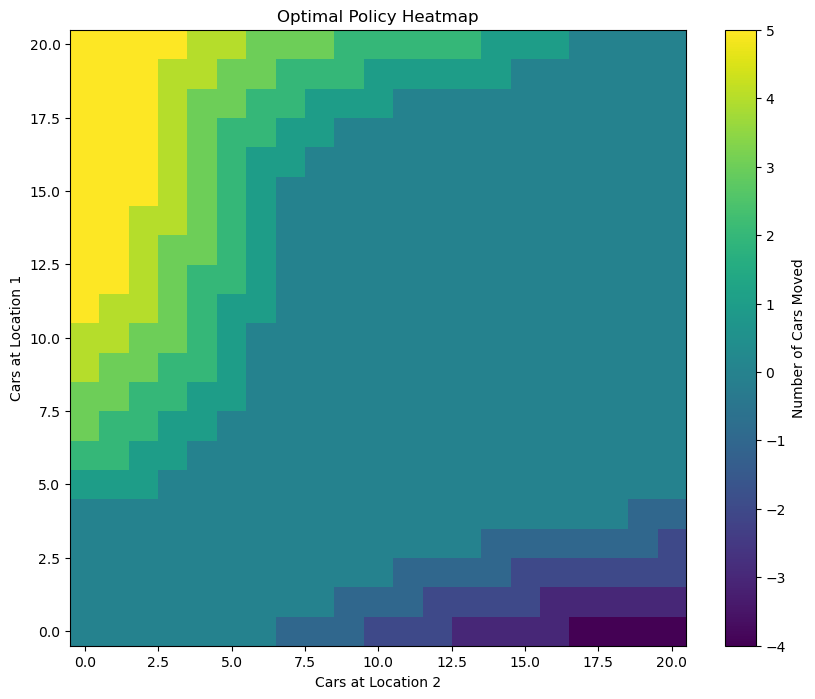

In [27]:
print("Optimal Policy:")
print(policy)

# Heatmap visualization
plt.figure(figsize=(10, 8))
plt.imshow(policy, cmap='viridis', origin='lower')
plt.colorbar(label='Number of Cars Moved')
plt.xlabel('Cars at Location 2')
plt.ylabel('Cars at Location 1')
plt.title('Optimal Policy Heatmap')
plt.show()
